# Titanic with neural network

In this notebook, I built a neural network model to predict survival on the Titanic dataset. I used PyTorch for model implementation and training, and I applied techniques like early stopping and learning rate scheduling to improve performance. The notebook includes data preprocessing, model definition, training loop, and evaluation of the model's performance on the test set.

TODO:
- Test different architectures (e.g., more layers, different activation functions)
- Improve the model with Name feature representation (flattening the name embeddings )
- I split the trainig data into train_train and train_val and, rougly, obtained a validation accuracy of 0.82. Should look into ways to improve this further, maybe with better hyperparameter tuning or more training epochs.
- For many of the hyperparameters I picked, I have the valuation accuracy greater than the test accuracy during training, which is unusual. This could be due to difference in train_train and train_val data. Should look into this.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

import numpy as np
import re
import copy

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [3]:
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")
print(train_df.shape)
print(test_df.shape)
train_df.head()

(891, 12)
(418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Exploratory Analysis

In [4]:
# CHecking for null values and data types
train_df.isnull().sum(), train_df.isnull().sum()

(PassengerId      0
 Survived         0
 Pclass           0
 Name             0
 Sex              0
 Age            177
 SibSp            0
 Parch            0
 Ticket           0
 Fare             0
 Cabin          687
 Embarked         2
 dtype: int64,
 PassengerId      0
 Survived         0
 Pclass           0
 Name             0
 Sex              0
 Age            177
 SibSp            0
 Parch            0
 Ticket           0
 Fare             0
 Cabin          687
 Embarked         2
 dtype: int64)

In [5]:
print("Value counts for Cabin:")
print(train_df.Cabin.value_counts())
print("\nValue counts for Embarked:") 
print(train_df.Embarked.value_counts())

Value counts for Cabin:
Cabin
G6             4
C23 C25 C27    4
B96 B98        4
F2             3
D              3
              ..
E17            1
A24            1
C50            1
B42            1
C148           1
Name: count, Length: 147, dtype: int64

Value counts for Embarked:
Embarked
S    644
C    168
Q     77
Name: count, dtype: int64


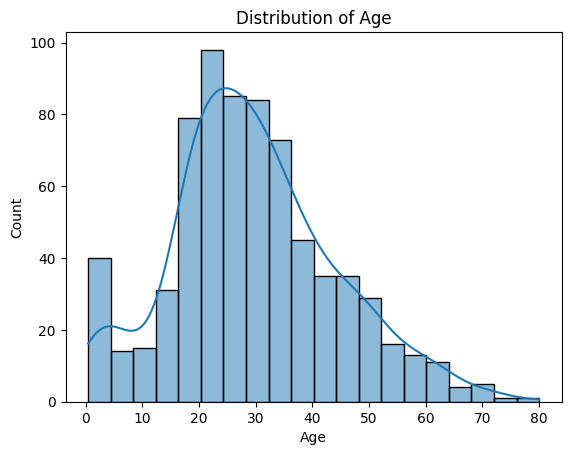

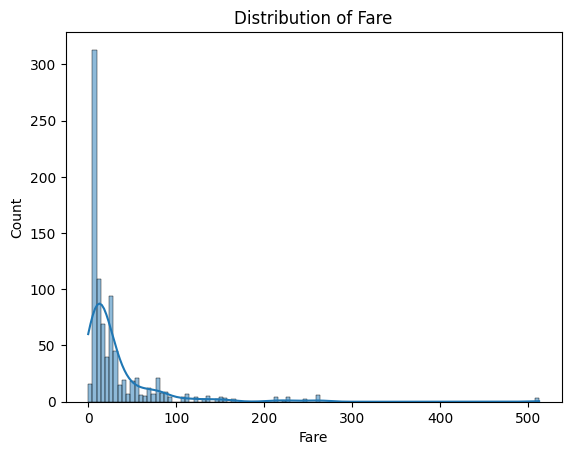

In [6]:
for col in ["Age", "Fare"]:
    sns.histplot(train_df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

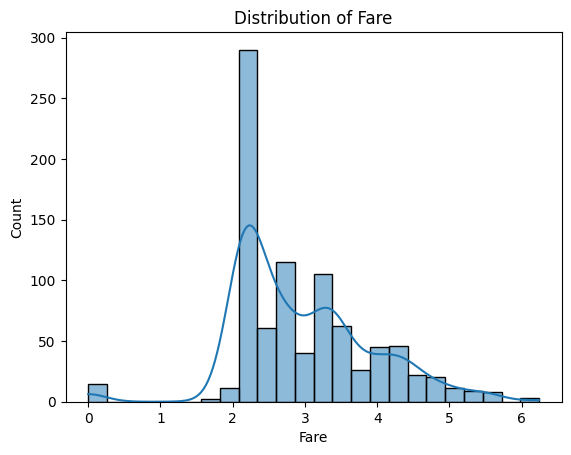

In [7]:
sns.histplot(np.log1p(train_df["Fare"]), kde=True) # because log is negative between 0 and 1, so log1p
plt.title(f"Distribution of Fare")
plt.show()

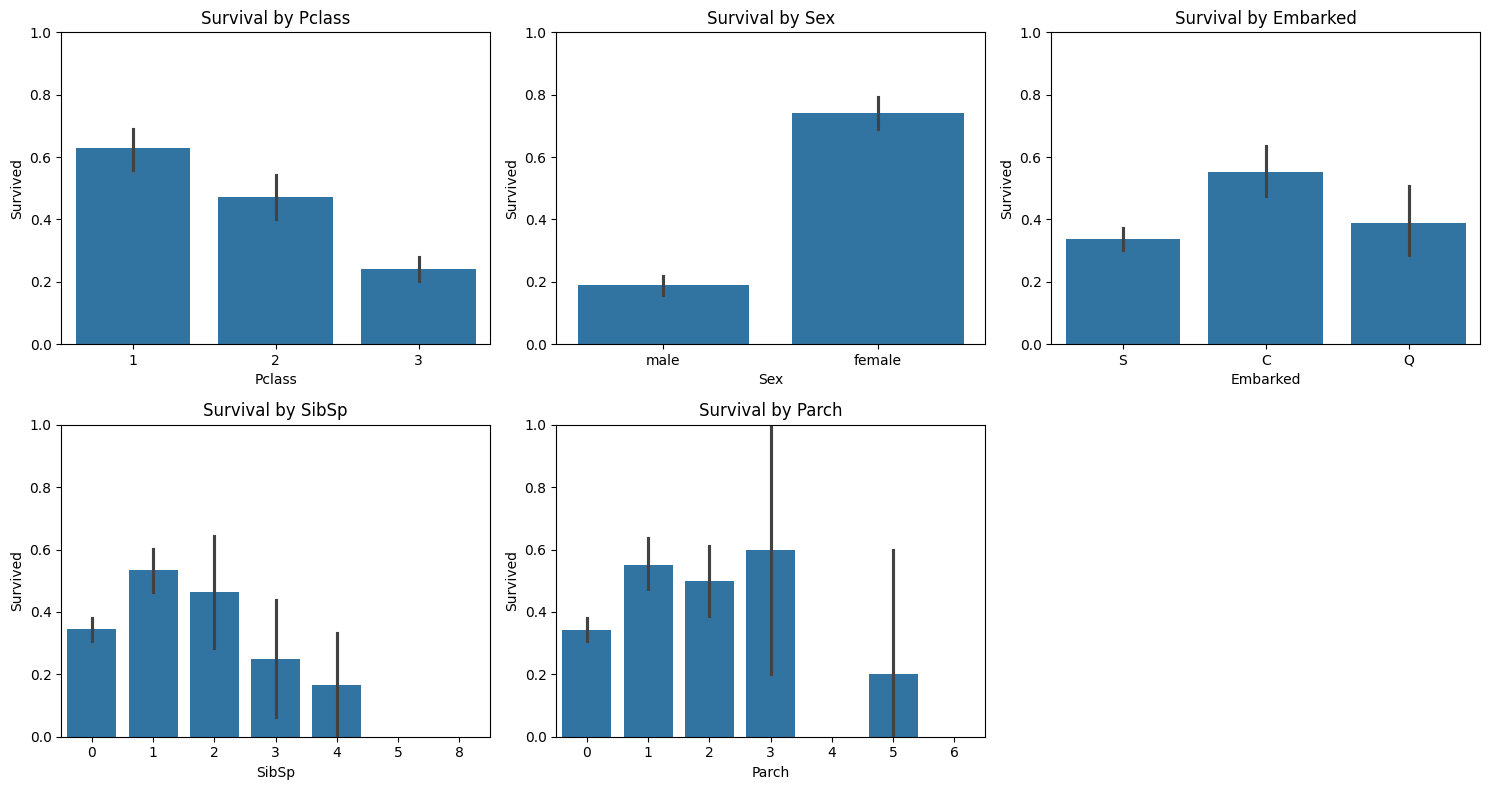

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(["Pclass", "Sex", "Embarked", "SibSp", "Parch"]):
    sns.barplot(x=col, y="Survived", data=train_df, ax=axes[i])
    axes[i].set_ylim(0, 1)
    axes[i].set_title(f"Survival by {col}")

# Remove the extra subplot
fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

In [9]:
def get_cabin_number(cabin_val):
    if type(cabin_val) is str:
        cabin_int = re.findall(r"\d+", cabin_val)
        cabin_int = [int(x) for x in cabin_int]
        if cabin_int:
            return max(cabin_int)
    return np.nan

def get_cabin_char(cabin_val):
    if type(cabin_val) is str:
        if cabin_val[0].isalpha():
            return cabin_val[0]
    return np.nan

def get_title(name_val):
    matches = re.findall(r"\s\w+\.", name_val)
    if len(matches):
        return matches[0]
    else:
        return np.nan

def get_marital_status(title_list):
    status = []
    for t in title_list:
        if "Mr." in t or "Mrs." in t:
            status.append(1)
        elif "Miss." in t or "Master." in t:
            status.append(0)
        else:
            status.append(-1)
    return status

Deck
C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: count, dtype: int64
687


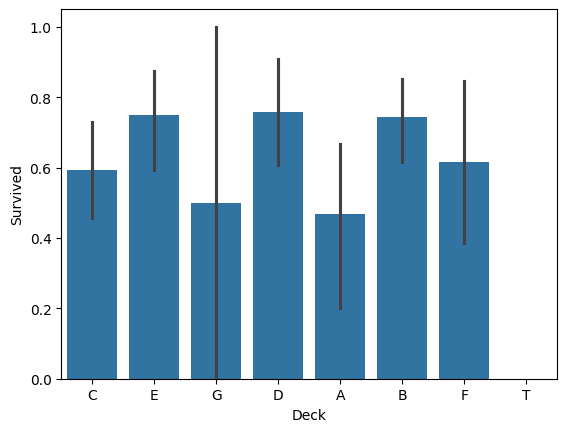

In [10]:
train_inspect_df = train_df.copy()
train_inspect_df['Deck'] = train_df['Cabin'].map(get_cabin_char)
sns.barplot(x="Deck", y="Survived", data=train_inspect_df)
print(train_inspect_df.Deck.value_counts())
print(train_inspect_df.Deck.isnull().sum())

In [11]:
deck_values = ["A", "B", "C", "D", "E", "F"] # because G and T have very few values, and to maintain consistency with test set.

def get_cabin_char_valid(cabin_val):
    cabin_char = get_cabin_char(cabin_val)
    if cabin_char in deck_values:
        return cabin_char
    return np.nan

## Data Preprocessing

In [12]:
all_names = train_df.Name.tolist()
all_words = set()

for name in all_names:
    cleaned_words = re.sub(r'[^a-z\s]', '', name.lower())
    all_words.update([word for word in cleaned_words.split()])
    
word_to_idx = {word: idx for idx, word in enumerate(sorted(all_words))}  # Deterministic ordering
name_vocab_size = len(word_to_idx)
print(f"Vocab size (Name): {name_vocab_size}")

Vocab size (Name): 1525


In [13]:
def prepare_sequence(seq_text, to_ix, default_idx=name_vocab_size):
    seq_text = re.sub(r'[^a-z\s]', '', seq_text.lower())
    seq = seq_text.split()
    idxs = [to_ix.get(w, default_idx) for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

train_names_vec = [prepare_sequence(name, word_to_idx) for name in train_df.Name]
test_names_vec = [prepare_sequence(name, word_to_idx) for name in test_df.Name]

all_names_vec = nn.utils.rnn.pad_sequence(train_names_vec + test_names_vec,
                                   padding_value=name_vocab_size,
                                   batch_first=True)

X_train_name = all_names_vec[: train_df.shape[0]]
X_test_name = all_names_vec[train_df.shape[0] :]
X_train_name.shape

torch.Size([891, 14])

In [14]:
def preprocess_data(input_df):
    X_df = input_df.copy()

    # Label unknown values
    X_df['CabinKnown'] = np.where(X_df['Cabin'].isnull(), 0, 1)
    X_df['AgeKnown'] = np.where(X_df['Age'].isnull(), 0, 1)

    # Feature engineering
    X_df['Deck'] = X_df['Cabin'].map(get_cabin_char_valid)
    X_df['CabinNum'] = X_df['Cabin'].map(get_cabin_number)
    title = X_df['Name'].map(get_title)
    X_df['Married'] = get_marital_status(title)
    X_df['Fare'] = np.log1p(X_df['Fare']) # log transform to reduce skewness

    # Imputation
    X_df.fillna({"Fare": X_df["Fare"].median(skipna=True),
                "Embarked": X_df["Embarked"].mode(dropna=True)[0],
                "CabinNum": X_df["CabinNum"].median(skipna=True),
                "Age": X_df["Age"].median(skipna=True)
                }, inplace=True)

    # One-hot encoding
    X_df = pd.get_dummies(X_df, columns=["Pclass","Sex", "Embarked"], drop_first=True, dtype=int)
    X_df = pd.get_dummies(X_df, columns=["Deck"], drop_first=False, dtype=int) # because Deck has a lot of missing values

    # Dropping irrelevant features
    X_df.drop('PassengerId', axis=1, inplace=True)
    X_df.drop(['Name', 'Cabin', 'Ticket'], axis=1, inplace=True)
    
    X_df.drop('Survived', axis=1, inplace=True, errors='ignore')

    return X_df

In [15]:
numeric_features = ['Age', 'Fare', 'CabinNum', 'SibSp', 'Parch']

# Apply preprocessing
X_train_other = preprocess_data(train_df)
X_test_other = preprocess_data(test_df)

assert X_train_other.shape[1] == X_test_other.shape[1], "Train and test sets have different number of features after preprocessing."



print(X_train_other.shape)
print("\nFirst few rows of processed data:")
print(X_train_other.head())

(891, 19)

First few rows of processed data:
    Age  SibSp  Parch      Fare  CabinKnown  AgeKnown  CabinNum  Married  \
0  22.0      1      0  2.110213           0         1      43.0        1   
1  38.0      1      0  4.280593           1         1      85.0        1   
2  26.0      0      0  2.188856           0         1      43.0        0   
3  35.0      1      0  3.990834           1         1     123.0        1   
4  35.0      0      0  2.202765           0         1      43.0        1   

   Pclass_2  Pclass_3  Sex_male  Embarked_Q  Embarked_S  Deck_A  Deck_B  \
0         0         1         1           0           1       0       0   
1         0         0         0           0           0       0       0   
2         0         1         0           0           1       0       0   
3         0         0         0           0           1       0       0   
4         0         1         1           0           1       0       0   

   Deck_C  Deck_D  Deck_E  Deck_F  
0       0  

In [16]:
# Check for any remaining null values
X_train_other.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         891 non-null    float64
 1   SibSp       891 non-null    int64  
 2   Parch       891 non-null    int64  
 3   Fare        891 non-null    float64
 4   CabinKnown  891 non-null    int64  
 5   AgeKnown    891 non-null    int64  
 6   CabinNum    891 non-null    float64
 7   Married     891 non-null    int64  
 8   Pclass_2    891 non-null    int64  
 9   Pclass_3    891 non-null    int64  
 10  Sex_male    891 non-null    int64  
 11  Embarked_Q  891 non-null    int64  
 12  Embarked_S  891 non-null    int64  
 13  Deck_A      891 non-null    int64  
 14  Deck_B      891 non-null    int64  
 15  Deck_C      891 non-null    int64  
 16  Deck_D      891 non-null    int64  
 17  Deck_E      891 non-null    int64  
 18  Deck_F      891 non-null    int64  
dtypes: float64(3), int64(16)
memo

In [17]:
# Check for any remaining null values
X_test_other.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         418 non-null    float64
 1   SibSp       418 non-null    int64  
 2   Parch       418 non-null    int64  
 3   Fare        418 non-null    float64
 4   CabinKnown  418 non-null    int64  
 5   AgeKnown    418 non-null    int64  
 6   CabinNum    418 non-null    float64
 7   Married     418 non-null    int64  
 8   Pclass_2    418 non-null    int64  
 9   Pclass_3    418 non-null    int64  
 10  Sex_male    418 non-null    int64  
 11  Embarked_Q  418 non-null    int64  
 12  Embarked_S  418 non-null    int64  
 13  Deck_A      418 non-null    int64  
 14  Deck_B      418 non-null    int64  
 15  Deck_C      418 non-null    int64  
 16  Deck_D      418 non-null    int64  
 17  Deck_E      418 non-null    int64  
 18  Deck_F      418 non-null    int64  
dtypes: float64(3), int64(16)
memo

## Model Building

In [18]:
# Early stopping: prevents overfitting by stopping when validation accuracy plateaus
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience  # Wait this many checks before stopping
        self.min_delta = min_delta  # Minimum improvement threshold
        self.counter = 0
        self.best_score = None
        self.early_stop = False

        self.best_state_dict = None  # To save the best model weights
        
    def __call__(self, val_acc, model):
        if self.best_score is None:
            self.best_score = val_acc
            self.best_state_dict = copy.deepcopy(model.state_dict())  # Deep copy to avoid mutation

        elif val_acc > self.best_score + self.min_delta:
            print(f"Validation accuracy improved from {self.best_score:.4f} to {val_acc:.4f}. Saving model.")
            self.best_score = val_acc
            self.best_state_dict = copy.deepcopy(model.state_dict())  # Deep copy to avoid mutation
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

### Without Name representation

In [19]:
class TitanicSurvivalModelOther(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.0):
        super(TitanicSurvivalModelOther, self).__init__()
        self.fc1 = nn.Linear(input_dim, 15)
        self.fc2 = nn.Linear(15, 8)
        self.fc3 = nn.Linear(8, 1)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

def model_other_accuracy(model, other_features, labels, print_report=False):
    model.eval()
    with torch.no_grad():
        outputs = model(other_features)
        predicted = (F.sigmoid(outputs) >= 0.5).float()  # Apply sigmoid for prediction
        accuracy = accuracy_score(labels.cpu(), predicted.cpu())
        if print_report:
            print(classification_report(labels.cpu(), predicted.cpu()))

    return accuracy

#### K-Fold Cross-Validation

In [20]:
# K-Fold Cross-Validation for more reliable performance estimates
seed = 3
np.random.seed(seed)
torch.manual_seed(seed)

n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seed)

# Store best results for all folds 
fold_train_accs = []
fold_val_accs = []

# Store epoch-wise metrics for all folds
all_fold_train_losses = []
all_fold_val_losses = []
all_fold_train_accs = []
all_fold_val_accs = []

# Model Hyperparameters
optimizer_lr = 0.05
dropout_rate = 0.1
scheduler_lr_factor = 0.1

print(f"Starting {n_folds}-Fold Cross-Validation\n")
print("="*60)

for fold, (train_idx, val_idx) in enumerate(kfold.split(train_df), 1):
    print(f"\nFold {fold}/{n_folds}")
    print("-"*60)
    
    # Normalize data separately for this fold to avoid data leakage
    scaler_fold = StandardScaler()
    X_train_fold_other_df = X_train_other.iloc[train_idx].copy()
    X_val_fold_other_df = X_train_other.iloc[val_idx].copy()
    
    # Fit scaler ONLY on training fold, then transform both train and val
    X_train_fold_other_df[numeric_features] = scaler_fold.fit_transform(X_train_fold_other_df[numeric_features])
    X_val_fold_other_df[numeric_features] = scaler_fold.transform(X_val_fold_other_df[numeric_features])
    
    # Split data for this fold
    X_train_fold_other = torch.tensor(X_train_fold_other_df.values, dtype=torch.float32).to(device)
    X_val_fold_other = torch.tensor(X_val_fold_other_df.values, dtype=torch.float32).to(device)
    
    y_train_fold = torch.tensor(train_df.iloc[train_idx]['Survived'].values, dtype=torch.float32).unsqueeze(1).to(device)
    y_val_fold = torch.tensor(train_df.iloc[val_idx]['Survived'].values, dtype=torch.float32).unsqueeze(1).to(device)
    
    # Initialize model, optimizer, and early stopping for this fold
    model_fold = TitanicSurvivalModelOther(X_train_fold_other.shape[1], dropout_rate=dropout_rate).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model_fold.parameters(), lr=optimizer_lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=scheduler_lr_factor, patience=3
    )
    
    early_stopping_fold = EarlyStopping(patience=8, min_delta=0.002)
    
    # Store metrics for this fold
    all_epoch_train_losses = []
    all_epoch_val_losses = []
    all_epoch_train_accs = []
    all_epoch_val_accs = []
    
    # Training loop for this fold
    num_epochs = 100
    batch_size = 64
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        
        model_fold.train()
        indices = torch.randperm(len(X_train_fold_other))
        for i in range(0, len(indices), batch_size):
            batch_indices = indices[i:i+batch_size]
            
            other_features = X_train_fold_other[batch_indices]
            target = y_train_fold[batch_indices]
            
            # Forward pass
            optimizer.zero_grad()
            output = model_fold(other_features)
            loss = criterion(output, target)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_train_loss = epoch_loss / (len(X_train_fold_other) / batch_size)
        
        # Validation
        model_fold.eval()
        with torch.no_grad():
            val_outputs = model_fold(X_val_fold_other)
            val_loss = criterion(val_outputs, y_val_fold)
            train_acc = model_other_accuracy(model_fold, X_train_fold_other, y_train_fold)
            val_acc = model_other_accuracy(model_fold, X_val_fold_other, y_val_fold)
        
        scheduler.step(val_acc)

        # Store metrics
        all_epoch_train_losses.append(avg_train_loss)
        all_epoch_val_losses.append(val_loss.item())
        all_epoch_train_accs.append(train_acc)
        all_epoch_val_accs.append(val_acc)
        
        # Early stopping check
        early_stopping_fold(val_acc, model=model_fold)
        if early_stopping_fold.early_stop:
            break
    
    # Store this fold's metrics
    all_fold_train_losses.append(all_epoch_train_losses)
    all_fold_val_losses.append(all_epoch_val_losses)
    all_fold_train_accs.append(all_epoch_train_accs)
    all_fold_val_accs.append(all_epoch_val_accs)
    
    # Load best model for final evaluation
    model_fold.load_state_dict(early_stopping_fold.best_state_dict)
    final_train_acc = model_other_accuracy(model_fold, X_train_fold_other, y_train_fold)
    final_val_acc = model_other_accuracy(model_fold, X_val_fold_other, y_val_fold)
    
    fold_train_accs.append(final_train_acc)
    fold_val_accs.append(final_val_acc)
    
    print(f"Fold {fold} - Train Acc: {final_train_acc:.4f}, Val Acc: {final_val_acc:.4f}, Epochs: {epoch+1}")

print("\n" + "="*60)
print("Cross-Validation Results:")
print("="*60)
print(f"Mean Train Accuracy: {np.mean(fold_train_accs):.4f} ± {np.std(fold_train_accs):.4f}")
print(f"Mean Val Accuracy:   {np.mean(fold_val_accs):.4f} ± {np.std(fold_val_accs):.4f}")
print("\nIndividual Fold Val Accuracies:", [f"{acc:.4f}" for acc in fold_val_accs])

Starting 5-Fold Cross-Validation


Fold 1/5
------------------------------------------------------------
Validation accuracy improved from 0.7374 to 0.7654. Saving model.
Validation accuracy improved from 0.7654 to 0.7821. Saving model.
Validation accuracy improved from 0.7821 to 0.8156. Saving model.
Fold 1 - Train Acc: 0.8244, Val Acc: 0.8156, Epochs: 14

Fold 2/5
------------------------------------------------------------
Validation accuracy improved from 0.7528 to 0.7697. Saving model.
Validation accuracy improved from 0.7697 to 0.7809. Saving model.
Validation accuracy improved from 0.7809 to 0.8034. Saving model.
Fold 2 - Train Acc: 0.8513, Val Acc: 0.8034, Epochs: 13

Fold 3/5
------------------------------------------------------------
Validation accuracy improved from 0.7079 to 0.8034. Saving model.
Validation accuracy improved from 0.8034 to 0.8371. Saving model.
Fold 3 - Train Acc: 0.8289, Val Acc: 0.8371, Epochs: 11

Fold 4/5
-----------------------------------------------

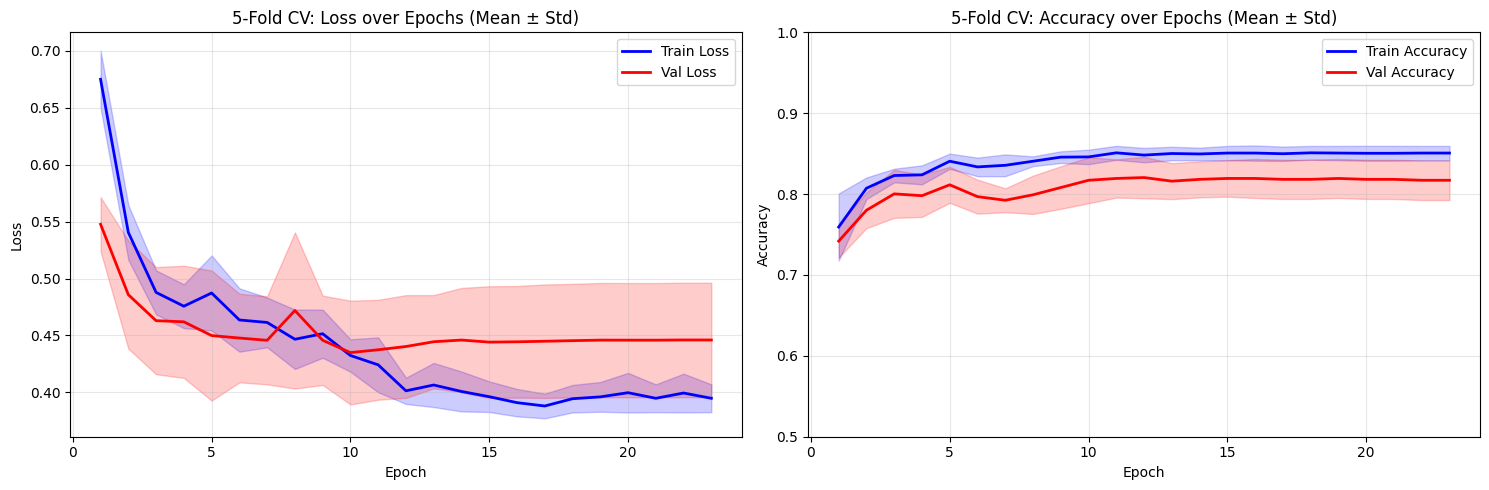

In [21]:
# Pad all fold histories to same length (some folds stop early)
max_epochs = max(len(fold) for fold in all_fold_train_losses)

# Pad with last value for folds that stopped early
padded_train_losses = []
padded_val_losses = []
padded_train_accs = []
padded_val_accs = []

for i in range(n_folds):
    train_loss = all_fold_train_losses[i] + [all_fold_train_losses[i][-1]] * (max_epochs - len(all_fold_train_losses[i]))
    val_loss = all_fold_val_losses[i] + [all_fold_val_losses[i][-1]] * (max_epochs - len(all_fold_val_losses[i]))
    train_acc = all_fold_train_accs[i] + [all_fold_train_accs[i][-1]] * (max_epochs - len(all_fold_train_accs[i]))
    val_acc = all_fold_val_accs[i] + [all_fold_val_accs[i][-1]] * (max_epochs - len(all_fold_val_accs[i]))
    
    padded_train_losses.append(train_loss)
    padded_val_losses.append(val_loss)
    padded_train_accs.append(train_acc)
    padded_val_accs.append(val_acc)

# Convert to numpy arrays
padded_train_losses = np.array(padded_train_losses)
padded_val_losses = np.array(padded_val_losses)
padded_train_accs = np.array(padded_train_accs)
padded_val_accs = np.array(padded_val_accs)

# Calculate mean and std across folds
mean_train_loss = padded_train_losses.mean(axis=0)
std_train_loss = padded_train_losses.std(axis=0)
mean_val_loss = padded_val_losses.mean(axis=0)
std_val_loss = padded_val_losses.std(axis=0)

mean_train_acc = padded_train_accs.mean(axis=0)
std_train_acc = padded_train_accs.std(axis=0)
mean_val_acc = padded_val_accs.mean(axis=0)
std_val_acc = padded_val_accs.std(axis=0)

# Plot Loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

epochs = np.arange(1, max_epochs + 1)

# Loss plot
ax1.plot(epochs, mean_train_loss, 'b-', label='Train Loss', linewidth=2)
ax1.fill_between(epochs, mean_train_loss - std_train_loss, mean_train_loss + std_train_loss, 
                  alpha=0.2, color='blue')
ax1.plot(epochs, mean_val_loss, 'r-', label='Val Loss', linewidth=2)
ax1.fill_between(epochs, mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, 
                  alpha=0.2, color='red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title(f'{n_folds}-Fold CV: Loss over Epochs (Mean ± Std)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(epochs, mean_train_acc, 'b-', label='Train Accuracy', linewidth=2)
ax2.fill_between(epochs, mean_train_acc - std_train_acc, mean_train_acc + std_train_acc, 
                  alpha=0.2, color='blue')
ax2.plot(epochs, mean_val_acc, 'r-', label='Val Accuracy', linewidth=2)
ax2.fill_between(epochs, mean_val_acc - std_val_acc, mean_val_acc + std_val_acc, 
                  alpha=0.2, color='red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_ylim([0.5, 1.0])
ax2.set_title(f'{n_folds}-Fold CV: Accuracy over Epochs (Mean ± Std)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### With Name representation

In [22]:
class TitanicSurvivalModel(nn.Module):
    def __init__(self, name_vocab_size, name_embedding_dim, other_feature_dim, dropout_rate=0.0):
        super(TitanicSurvivalModel, self).__init__()
        self.name_embedding = nn.Embedding(name_vocab_size + 1, name_embedding_dim)
        # Use mean pooling instead of flattening to remove bottleneck
        self.fc1 = nn.Linear(name_embedding_dim + other_feature_dim, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 1)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, name_vec, other_features):
        # Embed names and use mean pooling instead of flattening
        embedded = self.name_embedding(name_vec)  # (batch, seq_len, embedding_dim)
        embedded_mean = embedded.mean(dim=1)  # (batch, embedding_dim) - mean pooling removes sequence length dependency

        x = torch.cat((embedded_mean, other_features), dim=-1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  # No sigmoid - BCEWithLogitsLoss handles it
        return x

In [23]:
def model_accuracy(model, name_vec, other_features, labels, print_report=False):
    model.eval()
    with torch.no_grad():
        outputs = model(name_vec, other_features)
        predicted = (F.sigmoid(outputs) >= 0.5).float()  # Apply sigmoid for prediction
        accuracy = accuracy_score(labels.cpu(), predicted.cpu())
        if print_report:
            print(classification_report(labels.cpu(), predicted.cpu()))

    return accuracy

#### K-Fold Cross-Validation with Name Representation

In [37]:
# K-Fold Cross-Validation for Name + Other Features Model
seed = 3
np.random.seed(seed)
torch.manual_seed(seed)

n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seed)

# Store best results for all folds 
fold_train_accs_name = []
fold_val_accs_name = []

# Store epoch-wise metrics for all folds
all_fold_train_losses_name = []
all_fold_val_losses_name = []
all_fold_train_accs_name = []
all_fold_val_accs_name = []

# Model Hyperparameters
optimizer_lr = 0.02
dropout_rate = 0.2
name_embedding_dim = 8
scheduler_lr_factor = 0.2
optimizer_weight_decay = 5e-4

print(f"Starting {n_folds}-Fold Cross-Validation with Name Representation\n")
print("="*60)

for fold, (train_idx, val_idx) in enumerate(kfold.split(train_df), 1):
    print(f"\nFold {fold}/{n_folds}")
    print("-"*60)
    
    # Normalize data separately for this fold to avoid data leakage
    scaler_fold = StandardScaler()
    X_train_fold_other_df = X_train_other.iloc[train_idx].copy()
    X_val_fold_other_df = X_train_other.iloc[val_idx].copy()
    
    # Fit scaler ONLY on training fold, then transform both train and val
    X_train_fold_other_df[numeric_features] = scaler_fold.fit_transform(X_train_fold_other_df[numeric_features])
    X_val_fold_other_df[numeric_features] = scaler_fold.transform(X_val_fold_other_df[numeric_features])
    
    # Split data for this fold
    X_train_fold_name = X_train_name[train_idx].to(device)
    X_val_fold_name = X_train_name[val_idx].to(device)
    
    X_train_fold_other = torch.tensor(X_train_fold_other_df.values, dtype=torch.float32).to(device)
    X_val_fold_other = torch.tensor(X_val_fold_other_df.values, dtype=torch.float32).to(device)
    
    y_train_fold = torch.tensor(train_df.iloc[train_idx]['Survived'].values, dtype=torch.float32).unsqueeze(1).to(device)
    y_val_fold = torch.tensor(train_df.iloc[val_idx]['Survived'].values, dtype=torch.float32).unsqueeze(1).to(device)
    
    # Initialize model, optimizer, and early stopping for this fold
    model_fold = TitanicSurvivalModel(
        name_vocab_size=name_vocab_size,
        name_embedding_dim=name_embedding_dim,
        other_feature_dim=X_train_other.shape[1],
        dropout_rate=dropout_rate
    ).to(device)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model_fold.parameters(), lr=optimizer_lr, weight_decay=optimizer_weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=scheduler_lr_factor, patience=3
    )
    
    early_stopping_fold = EarlyStopping(patience=10, min_delta=0.002)
    
    # Store metrics for this fold
    all_epoch_train_losses = []
    all_epoch_val_losses = []
    all_epoch_train_accs = []
    all_epoch_val_accs = []
    
    # Training loop for this fold
    num_epochs = 100
    batch_size = 64
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        
        model_fold.train()
        indices = torch.randperm(len(X_train_fold_name))
        for i in range(0, len(indices), batch_size):
            batch_indices = indices[i:i+batch_size]
            
            name_vec = X_train_fold_name[batch_indices]
            other_features = X_train_fold_other[batch_indices]
            target = y_train_fold[batch_indices]
            
            # Forward pass
            optimizer.zero_grad()
            output = model_fold(name_vec, other_features)
            loss = criterion(output, target)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_train_loss = epoch_loss / (len(X_train_fold_name) / batch_size)
        
        # Validation
        model_fold.eval()
        with torch.no_grad():
            val_outputs = model_fold(X_val_fold_name, X_val_fold_other)
            val_loss = criterion(val_outputs, y_val_fold)
            train_acc = model_accuracy(model_fold, X_train_fold_name, X_train_fold_other, y_train_fold)
            val_acc = model_accuracy(model_fold, X_val_fold_name, X_val_fold_other, y_val_fold)
        
        scheduler.step(val_acc)

        # Store metrics
        all_epoch_train_losses.append(avg_train_loss)
        all_epoch_val_losses.append(val_loss.item())
        all_epoch_train_accs.append(train_acc)
        all_epoch_val_accs.append(val_acc)
        
        # Early stopping check
        early_stopping_fold(val_acc, model=model_fold)
        if early_stopping_fold.early_stop:
            break
    
    # Store this fold's metrics
    all_fold_train_losses_name.append(all_epoch_train_losses)
    all_fold_val_losses_name.append(all_epoch_val_losses)
    all_fold_train_accs_name.append(all_epoch_train_accs)
    all_fold_val_accs_name.append(all_epoch_val_accs)
    
    # Load best model for final evaluation
    model_fold.load_state_dict(early_stopping_fold.best_state_dict)
    final_train_acc = model_accuracy(model_fold, X_train_fold_name, X_train_fold_other, y_train_fold)
    final_val_acc = model_accuracy(model_fold, X_val_fold_name, X_val_fold_other, y_val_fold)
    
    fold_train_accs_name.append(final_train_acc)
    fold_val_accs_name.append(final_val_acc)
    
    print(f"Fold {fold} - Train Acc: {final_train_acc:.4f}, Val Acc: {final_val_acc:.4f}, Epochs: {epoch+1}")

print("\n" + "="*60)
print("Cross-Validation Results (Name + Other Features):")
print("="*60)
print(f"Mean Train Accuracy: {np.mean(fold_train_accs_name):.4f} ± {np.std(fold_train_accs_name):.4f}")
print(f"Mean Val Accuracy:   {np.mean(fold_val_accs_name):.4f} ± {np.std(fold_val_accs_name):.4f}")
print("\nIndividual Fold Val Accuracies:", [f"{acc:.4f}" for acc in fold_val_accs_name])

Starting 5-Fold Cross-Validation with Name Representation


Fold 1/5
------------------------------------------------------------
Validation accuracy improved from 0.7486 to 0.7542. Saving model.
Validation accuracy improved from 0.7542 to 0.7877. Saving model.
Validation accuracy improved from 0.7877 to 0.8045. Saving model.
Validation accuracy improved from 0.8045 to 0.8101. Saving model.
Fold 1 - Train Acc: 0.8933, Val Acc: 0.8101, Epochs: 25

Fold 2/5
------------------------------------------------------------
Validation accuracy improved from 0.6404 to 0.7753. Saving model.
Validation accuracy improved from 0.7753 to 0.7865. Saving model.
Validation accuracy improved from 0.7865 to 0.7978. Saving model.
Fold 2 - Train Acc: 0.8415, Val Acc: 0.7978, Epochs: 16

Fold 3/5
------------------------------------------------------------
Validation accuracy improved from 0.7528 to 0.8090. Saving model.
Validation accuracy improved from 0.8090 to 0.8371. Saving model.
Fold 3 - Train Acc: 0.

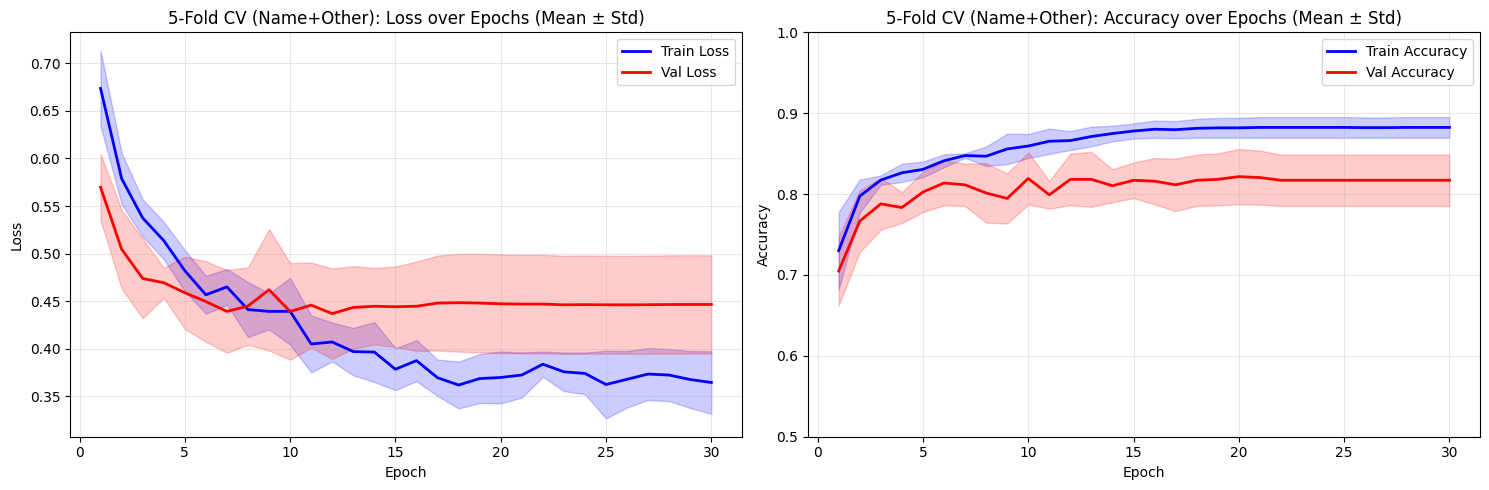

In [38]:
# Pad all fold histories to same length (some folds stop early)
max_epochs_name = max(len(fold) for fold in all_fold_train_losses_name)

# Pad with last value for folds that stopped early
padded_train_losses_name = []
padded_val_losses_name = []
padded_train_accs_name = []
padded_val_accs_name = []

for i in range(n_folds):
    train_loss = all_fold_train_losses_name[i] + [all_fold_train_losses_name[i][-1]] * (max_epochs_name - len(all_fold_train_losses_name[i]))
    val_loss = all_fold_val_losses_name[i] + [all_fold_val_losses_name[i][-1]] * (max_epochs_name - len(all_fold_val_losses_name[i]))
    train_acc = all_fold_train_accs_name[i] + [all_fold_train_accs_name[i][-1]] * (max_epochs_name - len(all_fold_train_accs_name[i]))
    val_acc = all_fold_val_accs_name[i] + [all_fold_val_accs_name[i][-1]] * (max_epochs_name - len(all_fold_val_accs_name[i]))
    
    padded_train_losses_name.append(train_loss)
    padded_val_losses_name.append(val_loss)
    padded_train_accs_name.append(train_acc)
    padded_val_accs_name.append(val_acc)

# Convert to numpy arrays
padded_train_losses_name = np.array(padded_train_losses_name)
padded_val_losses_name = np.array(padded_val_losses_name)
padded_train_accs_name = np.array(padded_train_accs_name)
padded_val_accs_name = np.array(padded_val_accs_name)

# Calculate mean and std across folds
mean_train_loss_name = padded_train_losses_name.mean(axis=0)
std_train_loss_name = padded_train_losses_name.std(axis=0)
mean_val_loss_name = padded_val_losses_name.mean(axis=0)
std_val_loss_name = padded_val_losses_name.std(axis=0)

mean_train_acc_name = padded_train_accs_name.mean(axis=0)
std_train_acc_name = padded_train_accs_name.std(axis=0)
mean_val_acc_name = padded_val_accs_name.mean(axis=0)
std_val_acc_name = padded_val_accs_name.std(axis=0)

# Plot Loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

epochs = np.arange(1, max_epochs_name + 1)

# Loss plot
ax1.plot(epochs, mean_train_loss_name, 'b-', label='Train Loss', linewidth=2)
ax1.fill_between(epochs, mean_train_loss_name - std_train_loss_name, mean_train_loss_name + std_train_loss_name, 
                  alpha=0.2, color='blue')
ax1.plot(epochs, mean_val_loss_name, 'r-', label='Val Loss', linewidth=2)
ax1.fill_between(epochs, mean_val_loss_name - std_val_loss_name, mean_val_loss_name + std_val_loss_name, 
                  alpha=0.2, color='red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title(f'{n_folds}-Fold CV (Name+Other): Loss over Epochs (Mean ± Std)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(epochs, mean_train_acc_name, 'b-', label='Train Accuracy', linewidth=2)
ax2.fill_between(epochs, mean_train_acc_name - std_train_acc_name, mean_train_acc_name + std_train_acc_name, 
                  alpha=0.2, color='blue')
ax2.plot(epochs, mean_val_acc_name, 'r-', label='Val Accuracy', linewidth=2)
ax2.fill_between(epochs, mean_val_acc_name - std_val_acc_name, mean_val_acc_name + std_val_acc_name, 
                  alpha=0.2, color='red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_ylim([0.5, 1.0])
ax2.set_title(f'{n_folds}-Fold CV (Name+Other): Accuracy over Epochs (Mean ± Std)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Results and Discussion
I see very similar performance with and without name representation, I was hoping that having names would give the model more information to work with and improve its predictions. The model with name representation only has a slightly higher mean validation accuracy, but the difference is not significant.

I will use the name representation model for the final test set evaluation, since it has a slightly better validation performance.
Chosen hyperparameters:
- optimizer_lr = 0.02
- dropout_rate = 0.2
- name_embedding_dim = 8
- scheduler_lr_factor = 0.2
- weight_decay = 5e-4

## Final Model Training and Predictions

In [39]:
# Prepare final training data (normalize using entire training set)
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Normalize numeric features for final model
scaler_final = StandardScaler()
X_train_other_final = X_train_other.copy()
X_test_other_final = X_test_other.copy()

X_train_other_final[numeric_features] = scaler_final.fit_transform(X_train_other[numeric_features])
X_test_other_final[numeric_features] = scaler_final.transform(X_test_other[numeric_features])

# Convert to tensors
X_train_name_final = X_train_name.to(device)
X_test_name_final = X_test_name.to(device)

X_train_other_final_tensor = torch.tensor(X_train_other_final.values, dtype=torch.float32).to(device)
X_test_other_final_tensor = torch.tensor(X_test_other_final.values, dtype=torch.float32).to(device)

y_train_final = torch.tensor(train_df['Survived'].values, dtype=torch.float32).unsqueeze(1).to(device)

print(f"Final training data shapes:")
print(f"  X_train_name: {X_train_name_final.shape}")
print(f"  X_train_other: {X_train_other_final_tensor.shape}")
print(f"  y_train: {y_train_final.shape}")
print(f"\nTest data shapes:")
print(f"  X_test_name: {X_test_name_final.shape}")
print(f"  X_test_other: {X_test_other_final_tensor.shape}")

Final training data shapes:
  X_train_name: torch.Size([891, 14])
  X_train_other: torch.Size([891, 19])
  y_train: torch.Size([891, 1])

Test data shapes:
  X_test_name: torch.Size([418, 14])
  X_test_other: torch.Size([418, 19])


In [47]:
# Initialize final model with best hyperparameters from CV
final_model = TitanicSurvivalModel(
    name_vocab_size=name_vocab_size,
    name_embedding_dim=name_embedding_dim,
    other_feature_dim=X_train_other.shape[1],
    dropout_rate=dropout_rate
).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(final_model.parameters(), lr=optimizer_lr*0.5, 
                       weight_decay=optimizer_weight_decay)
# Scheduler is actually not needed here, there for completeness
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=scheduler_lr_factor, patience=3
)

print(f"Final model architecture:")
print(final_model)
print(f"\nTotal parameters: {sum(p.numel() for p in final_model.parameters())}")

Final model architecture:
TitanicSurvivalModel(
  (name_embedding): Embedding(1526, 8)
  (fc1): Linear(in_features=27, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Total parameters: 12989


In [48]:
# Train final model on entire training set
batch_size = 64

max_allowed_training_acc = 0.9

train_losses = []
train_accs = []

print("Training final model on entire training set...\n")

for epoch in range(num_epochs):
    epoch_loss = 0.0
    
    final_model.train()
    indices = torch.randperm(len(X_train_name_final))
    
    for i in range(0, len(indices), batch_size):
        batch_indices = indices[i:i+batch_size]
        
        name_vec = X_train_name_final[batch_indices]
        other_features = X_train_other_final_tensor[batch_indices]
        target = y_train_final[batch_indices]
        
        # Forward pass
        optimizer.zero_grad()
        output = final_model(name_vec, other_features)
        loss = criterion(output, target)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / (len(X_train_name_final) / batch_size)
    
    # Evaluate on training set
    final_model.eval()
    with torch.no_grad():
        train_acc = model_accuracy(final_model, X_train_name_final, X_train_other_final_tensor, y_train_final)
    
    scheduler.step(train_acc)
    
    train_losses.append(avg_train_loss)
    train_accs.append(train_acc)
    
    # Save best model
    if train_acc > max_allowed_training_acc:
        best_train_acc = train_acc
        best_model_state = copy.deepcopy(final_model.state_dict())
        break

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}")

print(f"\nTraining completed!")
print(f"Best training accuracy: {best_train_acc:.4f}")

# Load best model
final_model.load_state_dict(best_model_state)

Training final model on entire training set...

Epoch [1/150], Loss: 0.6500, Train Acc: 0.6162
Epoch [2/150], Loss: 0.5837, Train Acc: 0.7632
Epoch [3/150], Loss: 0.5150, Train Acc: 0.7969
Epoch [4/150], Loss: 0.4703, Train Acc: 0.8025
Epoch [5/150], Loss: 0.4735, Train Acc: 0.8182
Epoch [6/150], Loss: 0.4594, Train Acc: 0.8215
Epoch [7/150], Loss: 0.4494, Train Acc: 0.8373
Epoch [8/150], Loss: 0.4362, Train Acc: 0.8260
Epoch [9/150], Loss: 0.4274, Train Acc: 0.8474
Epoch [10/150], Loss: 0.4046, Train Acc: 0.8451
Epoch [11/150], Loss: 0.4049, Train Acc: 0.8530
Epoch [12/150], Loss: 0.3944, Train Acc: 0.8631
Epoch [13/150], Loss: 0.3956, Train Acc: 0.8653
Epoch [14/150], Loss: 0.3789, Train Acc: 0.8664
Epoch [15/150], Loss: 0.3691, Train Acc: 0.8777
Epoch [16/150], Loss: 0.3710, Train Acc: 0.8810
Epoch [17/150], Loss: 0.3398, Train Acc: 0.8923
Epoch [18/150], Loss: 0.3357, Train Acc: 0.8923

Training completed!
Best training accuracy: 0.9046


<All keys matched successfully>

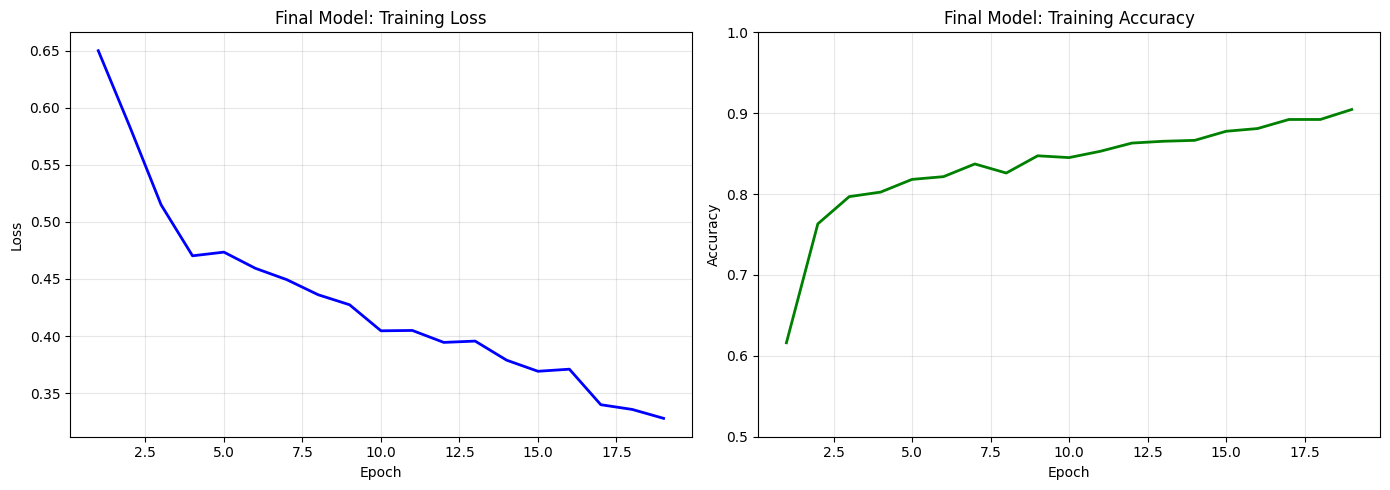

In [49]:
# Plot training progress
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

epochs_range = np.arange(1, len(train_losses) + 1)

ax1.plot(epochs_range, train_losses, 'b-', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Final Model: Training Loss')
ax1.grid(True, alpha=0.3)

ax2.plot(epochs_range, train_accs, 'g-', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Final Model: Training Accuracy')
ax2.set_ylim([0.5, 1.0])
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [50]:
# Make predictions on test set
final_model.eval()
with torch.no_grad():
    test_outputs = final_model(X_test_name_final, X_test_other_final_tensor)
    test_predictions = (F.sigmoid(test_outputs) >= 0.5).float().cpu().numpy().flatten().astype(int)

print(f"Test predictions shape: {test_predictions.shape}")
print(f"Predictions distribution:")
print(f"  Survived (1): {(test_predictions == 1).sum()}")
print(f"  Not survived (0): {(test_predictions == 0).sum()}")
print(f"\nFirst 10 predictions: {test_predictions[:10]}")

Test predictions shape: (418,)
Predictions distribution:
  Survived (1): 148
  Not survived (0): 270

First 10 predictions: [0 0 0 0 1 0 1 0 1 0]


In [51]:
# Create submission file
submission_df = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': test_predictions
})

print("\nSubmission file preview:")
print(submission_df.head(10))
print(f"\nTotal submissions: {len(submission_df)}")

# Save to CSV
submission_df.to_csv('submission.csv', index=False)
print("\nSubmission file saved as 'submission.csv'")


Submission file preview:
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1
5          897         0
6          898         1
7          899         0
8          900         1
9          901         0

Total submissions: 418

Submission file saved as 'submission.csv'
